In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/scratch/eberha0001/slurm-job.666786/ipykernel_2679950/47907170.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from rdkit import Chem
from grakel.kernels import WeisfeilerLehman
from gpytorch.kernels import RBFKernel
from gpytorch.priors import NormalPrior
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn.models import GIN, GAT, GCN, GraphSAGE

from mobius import ExpectedImprovement, Pool, Planner
from mobius import GPGKModel, GPModel, GPGNNModel
from mobius import Graph, Map4Fingerprint
from mobius import TanimotoSimilarityKernel

## Permeability dataset

Citation: CycPeptMPDB: A Comprehensive Database of Membrane Permeability of Cyclic Peptides; Jianan Li, et al.; 2023; https://doi.org/10.1021/acs.jcim.2c01573

In [3]:
dataset = pd.read_csv('../../data/CycPeptMPDB_Peptide_All.csv')
subset = dataset[['SMILES', 'Permeability']].copy().dropna()

/scratch/eberha0001/slurm-job.666786/ipykernel_2679950/2828601079.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../../data/CycPeptMPDB_Peptide_All.csv')


In [4]:
# Anything below -10
subset = subset[(subset['Permeability'] > -10)].copy()

In [5]:
# For removing duplicates
inchikeys = [Chem.MolToInchi(Chem.MolFromSmiles(smiles)) for smiles in subset['SMILES'].values]
subset['InChiKey'] = inchikeys

subset = subset.drop_duplicates('InChiKey')

[13:49:32] WARNING: Charges were rearranged



In [6]:
# Sort by permeability values, from worst (-10) to best (-4)
subset = subset.sort_values(by='Permeability', ascending=True)

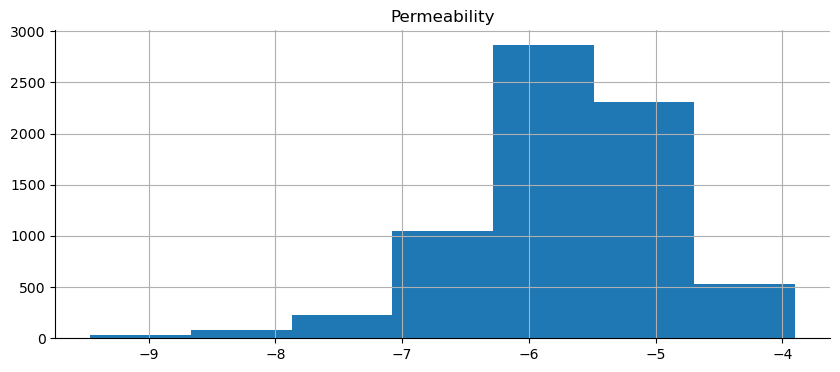

In [100]:
fig, axarr = plt.subplots(1, figsize=(10, 4))

subset.hist(ax=axarr, bins=7)

sns.despine()

plt.savefig('figure_distributions_permeability_values.png', dpi=300, bbox_inches='tight')

plt.show()

## Random search

In [8]:
pool = subset.copy()

peptides = pool['SMILES'][:96].values
scores = pool['Permeability'][:96].values

data = [('random', 0, p, s) for p, s in zip(peptides, scores)]

pool = pool[~pool['SMILES'].isin(peptides)]

for i in range(5):
    suggested_peptides = np.random.choice(subset['SMILES'], size=96, replace=False)
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    pool = pool[~pool['SMILES'].isin(suggested_peptides)]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('random', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmax(scores)]
    best_scores = np.max(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_random.csv', index=False)

Best peptide: CC(C)C[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N1C / -4.000

Best peptide: CC(C)C[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N1C / -4.000

Best peptide: CC(C)C[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N1C / -4.000

Best peptide: CC(C)C[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N1C / -4.000

Best peptide: CC(C)C[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N1C / -4.000



## Graph kernel

In [10]:
graph_convertor = Graph(input_type='smiles', output_type='grakel')
kernel = WeisfeilerLehman(normalize=True, n_iter=5)
gpmodel = GPGKModel(kernel=kernel, transform=graph_convertor)#, noise_prior=NormalPrior(loc=0, scale=1))

In [11]:
acq = ExpectedImprovement(gpmodel, maximize=True)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [12]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [13]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('WL', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('WL', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmax(scores)]
    best_scores = np.max(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_WL.csv', index=False)

Fitting GPGK model (cpu): 21step [00:07,  2.74step/s, loss=0.488]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C(=O)[C@H](CCCC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.300



Fitting GPGK model (cpu): 17step [00:09,  1.79step/s, loss=1.16]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 20step [00:18,  1.10step/s, loss=1.19]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 18step [00:24,  1.38s/step, loss=1.12]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 16step [00:29,  1.85s/step, loss=1.09]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



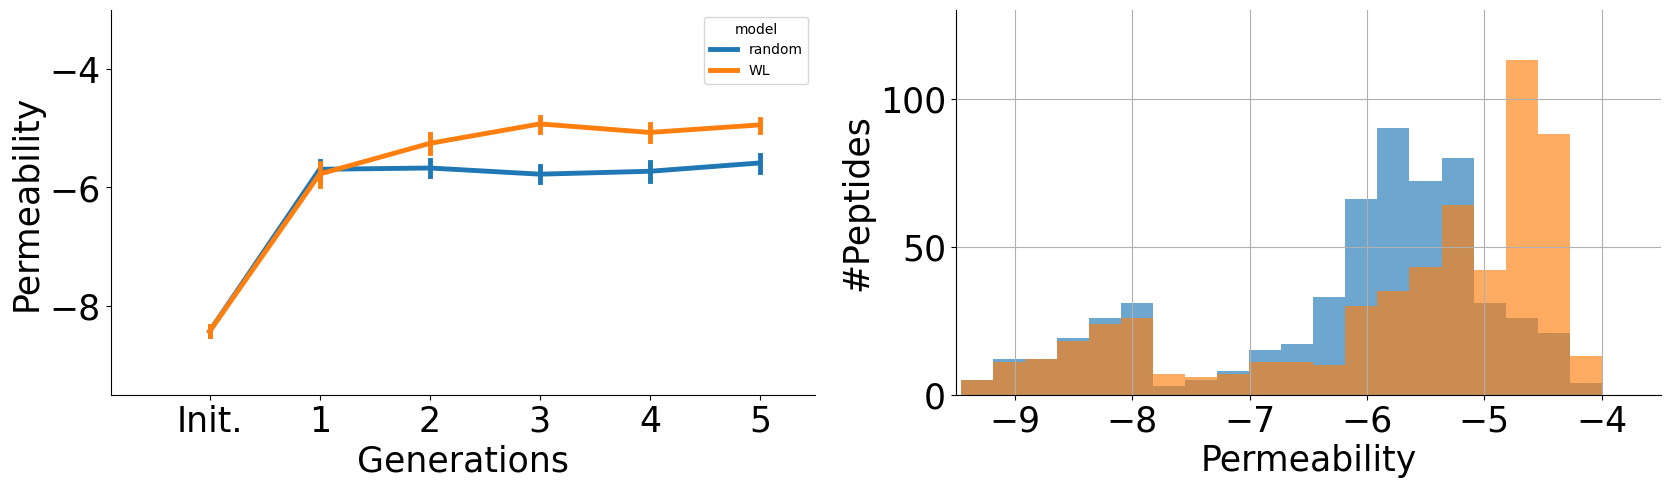

In [95]:
df_random = pd.read_csv('results_optimization_random.csv')
df = pd.read_csv('results_optimization_WL.csv')
df = pd.concat([df_random, df])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-9.5, -3])
ax[0].set_ylabel('Permeability', fontsize=25)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'WL']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-9.5, -3.5])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Permeability', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## MAP4 fingerprint

In [15]:
map4 = Map4Fingerprint(input_type='smiles', chiral=False)
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)

In [16]:
acq = ExpectedImprovement(gp, maximize=True)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [17]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [18]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmax(scores)]
    best_scores = np.max(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4.csv', index=False)

Fitting GP model (cpu): 16step [00:00, 136.60step/s, loss=0.448]


Best peptide: CC(C)C[C@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](Cc2ccc(O)cc2)C(=O)N[C@H](CC(C)C)C(=O)N1C / -4.300



Fitting GP model (cpu): 16step [00:00, 67.82step/s, loss=1.01]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GP model (cpu): 14step [00:00, 59.07step/s, loss=0.835]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GP model (cpu): 15step [00:00, 25.11step/s, loss=0.729]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GP model (cpu): 15step [00:01, 10.57step/s, loss=0.737]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



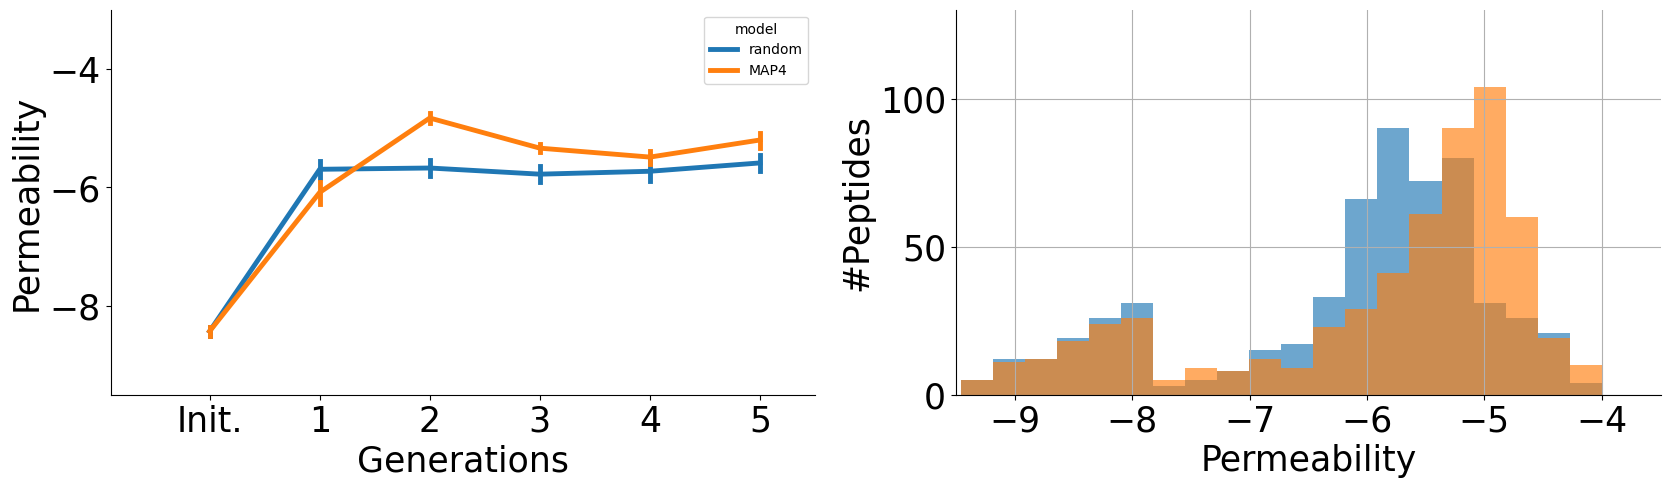

In [94]:
df_random = pd.read_csv('results_optimization_random.csv')
df = pd.read_csv('results_optimization_MAP4.csv')
df = pd.concat([df_random, df])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-9.5, -3])
ax[0].set_ylabel('Permeability', fontsize=25)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'MAP4']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-9.5, -3.5])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Permeability', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## MAP4 chiral fingerprint

In [20]:
map4 = Map4Fingerprint(input_type='smiles', chiral=True)
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)

In [21]:
acq = ExpectedImprovement(gp, maximize=True)
optimizer = Pool(subset['SMILES'].values)
ps = Planner(acq, optimizer)

In [22]:
seed_library = subset['SMILES'][:96].values
scores_seed_library = subset['Permeability'][:96].values

In [23]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4C', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4C', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmax(scores)]
    best_scores = np.max(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4C.csv', index=False)

Fitting GP model (cpu): 20step [00:00, 83.29step/s, loss=0.446] 


Best peptide: CC(C)C[C@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N2CCC[C@@H]2C(=O)N(C)[C@@H](Cc2ccc(O)cc2)C(=O)N(C)[C@H](CC(C)C)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](CC(C)C)C(=O)N(C)[C@H](C)C(=O)N1C / -4.620



Fitting GP model (cpu): 14step [00:00, 98.50step/s, loss=1.05]


Best peptide: CC(C)C[C@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](CC(C)C)C(=O)N1C / -4.000



Fitting GP model (cpu): 14step [00:00, 59.72step/s, loss=0.903]


Best peptide: CC(C)C[C@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](CC(C)C)C(=O)N1C / -4.000



Fitting GP model (cpu): 12step [00:00, 30.73step/s, loss=0.805]


Best peptide: CC(C)C[C@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](CC(C)C)C(=O)N1C / -4.000



Fitting GP model (cpu): 11step [00:00, 25.85step/s, loss=0.758]


Best peptide: CC(C)C[C@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](CC(C)C)C(=O)N1C / -4.000



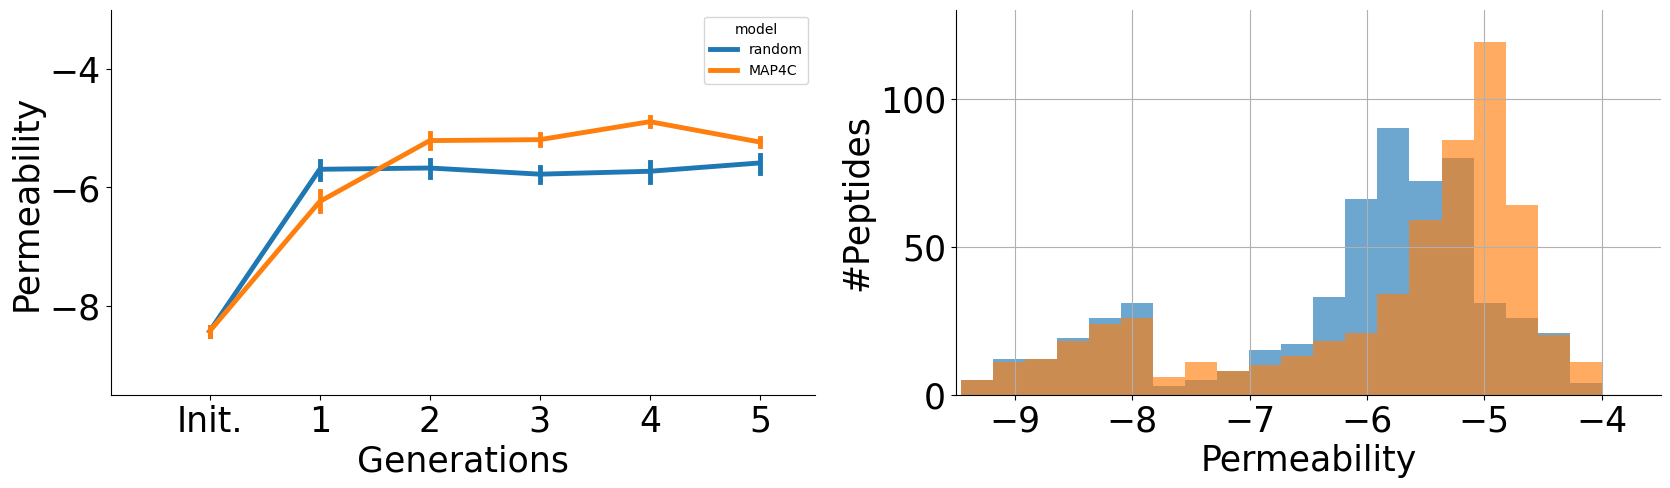

In [93]:
df_random = pd.read_csv('results_optimization_random.csv')
df = pd.read_csv('results_optimization_MAP4C.csv')
df = pd.concat([df_random, df])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-9.5, -3])
ax[0].set_ylabel('Permeability', fontsize=25)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'MAP4C']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-9.5, -3.5])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Permeability', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## GNN models

In [25]:
graph_convertor = Graph(input_type='smiles', output_type='pyg')
graphs = graph_convertor.transform(subset['SMILES'].values[0])

In [26]:
class GNNModel(torch.nn.Module):
    def __init__(self, model_name, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        models = {'GIN': GIN, 'GAT': GAT, 'GCN': GCN, 'GraphSAGE': GraphSAGE}
        gnn_model = models[model_name]

        self.model = gnn_model(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, 
                               out_channels=out_channels, dropout=dropout)
        
        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x

In [27]:
models = ['GAT', 'GraphSAGE', 'GCN', 'GIN']

for model in models:
    print(model)

    # define model
    gnn = GNNModel(model, in_channels=graphs.node_attr.shape[1], hidden_channels=256, out_channels=256, num_layers=4, dropout=0.25)
    gpmodel = GPGNNModel(kernel=RBFKernel(ard_num_dims=256, eps=1e-2), model=gnn, transform=graph_convertor)

    # define acquisition function, optimizer and planner
    acq = ExpectedImprovement(gpmodel , maximize=True)
    optimizer = Pool(subset['SMILES'].values)
    ps = Planner(acq, optimizer)

    # define seed library
    seed_library = subset['SMILES'][:96].values
    scores_seed_library = subset['Permeability'][:96].values

    peptides = seed_library.copy()
    scores = scores_seed_library.copy()
    
    # Store data for later analysis
    data = [(model, 0, p, s) for p, s in zip(peptides, scores)]
    
    for i in range(5):
        suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)
    
        # Get real permeability scores
        scores_suggested_peptides = [subset[subset['SMILES'] == p]['Permeability'].values[0] for p in suggested_peptides]
    
        peptides = np.concatenate([peptides, suggested_peptides])
        scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
        data.extend([(model, i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])
    
        best_seq = peptides[np.argmax(scores)]
        best_scores = np.max(scores)
        print('Best peptide: %s / %.3f' % (best_seq, best_scores))
        print('')
    
    df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
    df.to_csv(f'results_optimization_{model}.csv', index=False)


GAT


Fitting GPGNN model (cpu): 8step [00:03,  2.39step/s, loss=0.701]


Best peptide: CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)C[C@H](C)NC1=O / -4.150



Fitting GPGNN model (cpu): 7step [00:07,  1.02s/step, loss=1.8] 


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 1step [00:04,  4.97s/step, loss=1.91]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 4step [00:10,  2.59s/step, loss=1.66]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 6step [00:19,  3.30s/step, loss=1.58]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000

GraphSAGE


Fitting GPGNN model (cpu): 10step [00:03,  2.54step/s, loss=0.667]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](C(C)C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@H](C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@H](C(C)C)N(C)C(=O)[C@H]2CCCN2C(=O)[C@H](CC(C)C)NC(=O)[C@H](C)N(C)C1=O / -4.300



Fitting GPGNN model (cpu): 6step [00:04,  1.24step/s, loss=1.63]


Best peptide: CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)C[C@H](C)NC1=O / -4.150



Fitting GPGNN model (cpu): 9step [00:10,  1.15s/step, loss=1.4] 


Best peptide: CC(C)C[C@@H]1NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 8step [00:15,  1.98s/step, loss=1.34]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 8step [00:16,  2.10s/step, loss=1.18]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000

GCN


Fitting GPGNN model (cpu): 8step [00:02,  3.80step/s, loss=0.694]


Best peptide: CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)C[C@H](C)NC1=O / -4.150



Fitting GPGNN model (cpu): 15step [00:07,  1.96step/s, loss=1.43]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 4step [00:05,  1.41s/step, loss=1.49]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 1step [00:06,  6.60s/step, loss=1.53]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 6step [00:14,  2.42s/step, loss=1.44]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000

GIN


Fitting GPGNN model (cpu): 9step [00:03,  2.44step/s, loss=0.66] 


Best peptide: CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)C[C@H](C)NC1=O / -4.150



Fitting GPGNN model (cpu): 4step [00:04,  1.17s/step, loss=1.92]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 9step [00:13,  1.45s/step, loss=1.63]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 5step [00:15,  3.11s/step, loss=1.6] 


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



Fitting GPGNN model (cpu): 3step [00:17,  5.78s/step, loss=1.55]


Best peptide: CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H]2CCCN2C1=O / -4.000



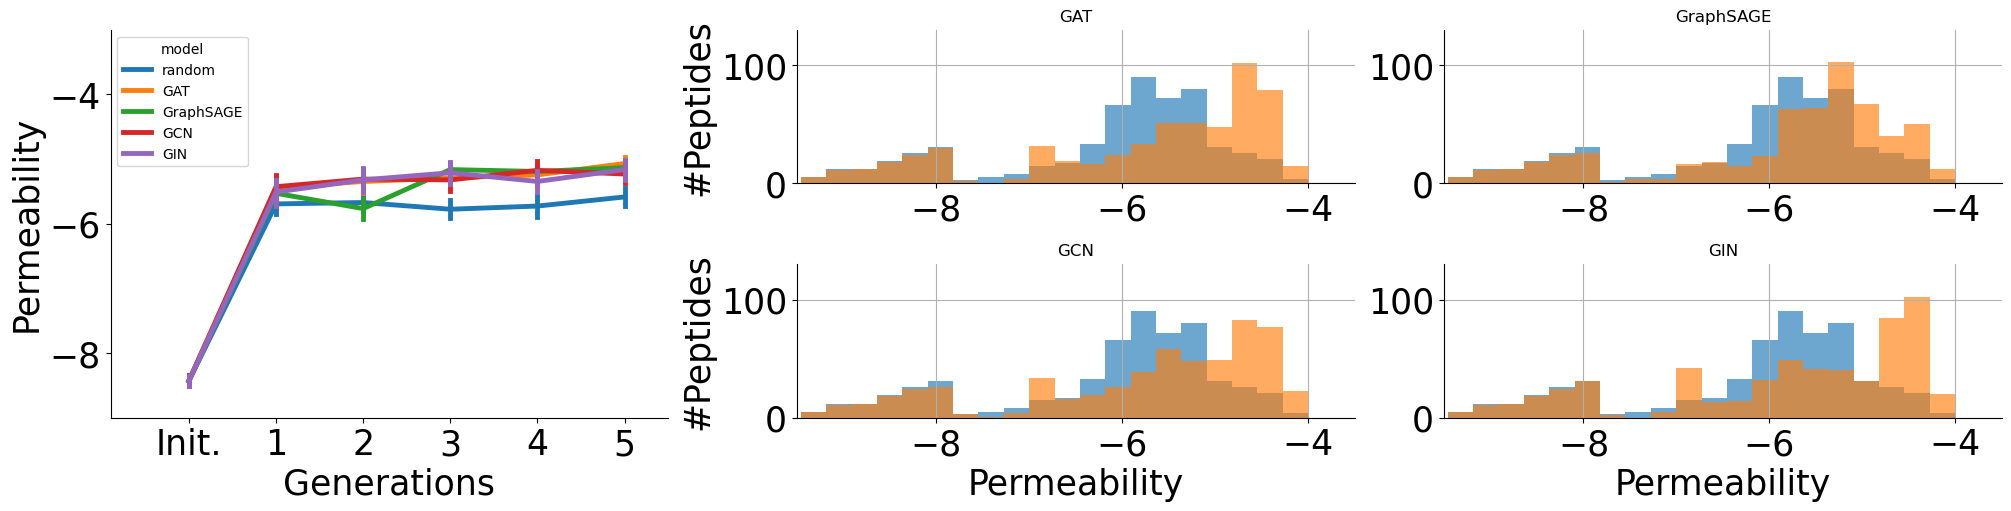

In [96]:
models = ['random', 'GAT', 'GraphSAGE', 'GCN', 'GIN']

df = pd.concat([pd.read_csv(f'results_optimization_{model}.csv') for model in models])

axarr = plt.figure(figsize=(20, 5), layout="constrained").subplot_mosaic(
    """
    ABC
    ADE
    """
)

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=axarr['A'], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

axarr['A'].set_xlim([-0.9, 5.5])
axarr['A'].set_ylim([-9, -3])
axarr['A'].set_ylabel('Permeability', fontsize=25)
axarr['A'].set_xlabel('Generations', fontsize=25)
axarr['A'].xaxis.set_tick_params(labelsize=25)
axarr['A'].yaxis.set_tick_params(labelsize=25)

models = ['GAT', 'GraphSAGE', 'GCN', 'GIN']

for ax, model in zip(['B', 'C', 'D', 'E'], models):
    df[df['model'] == 'random']['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    df[df['model'] == model]['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    axarr[ax].set_xlim([-9.5, -3.5])
    axarr[ax].set_ylim([0, 130])
    axarr[ax].xaxis.set_tick_params(labelsize=25)
    axarr[ax].yaxis.set_tick_params(labelsize=25)
    axarr[ax].set_title(model)

axarr['D'].set_xlabel('Permeability', fontsize=25)
axarr['E'].set_xlabel('Permeability', fontsize=25)
axarr['B'].set_ylabel('#Peptides', fontsize=25)
axarr['D'].set_ylabel('#Peptides', fontsize=25)

sns.despine()
plt.show()

# Results comparison

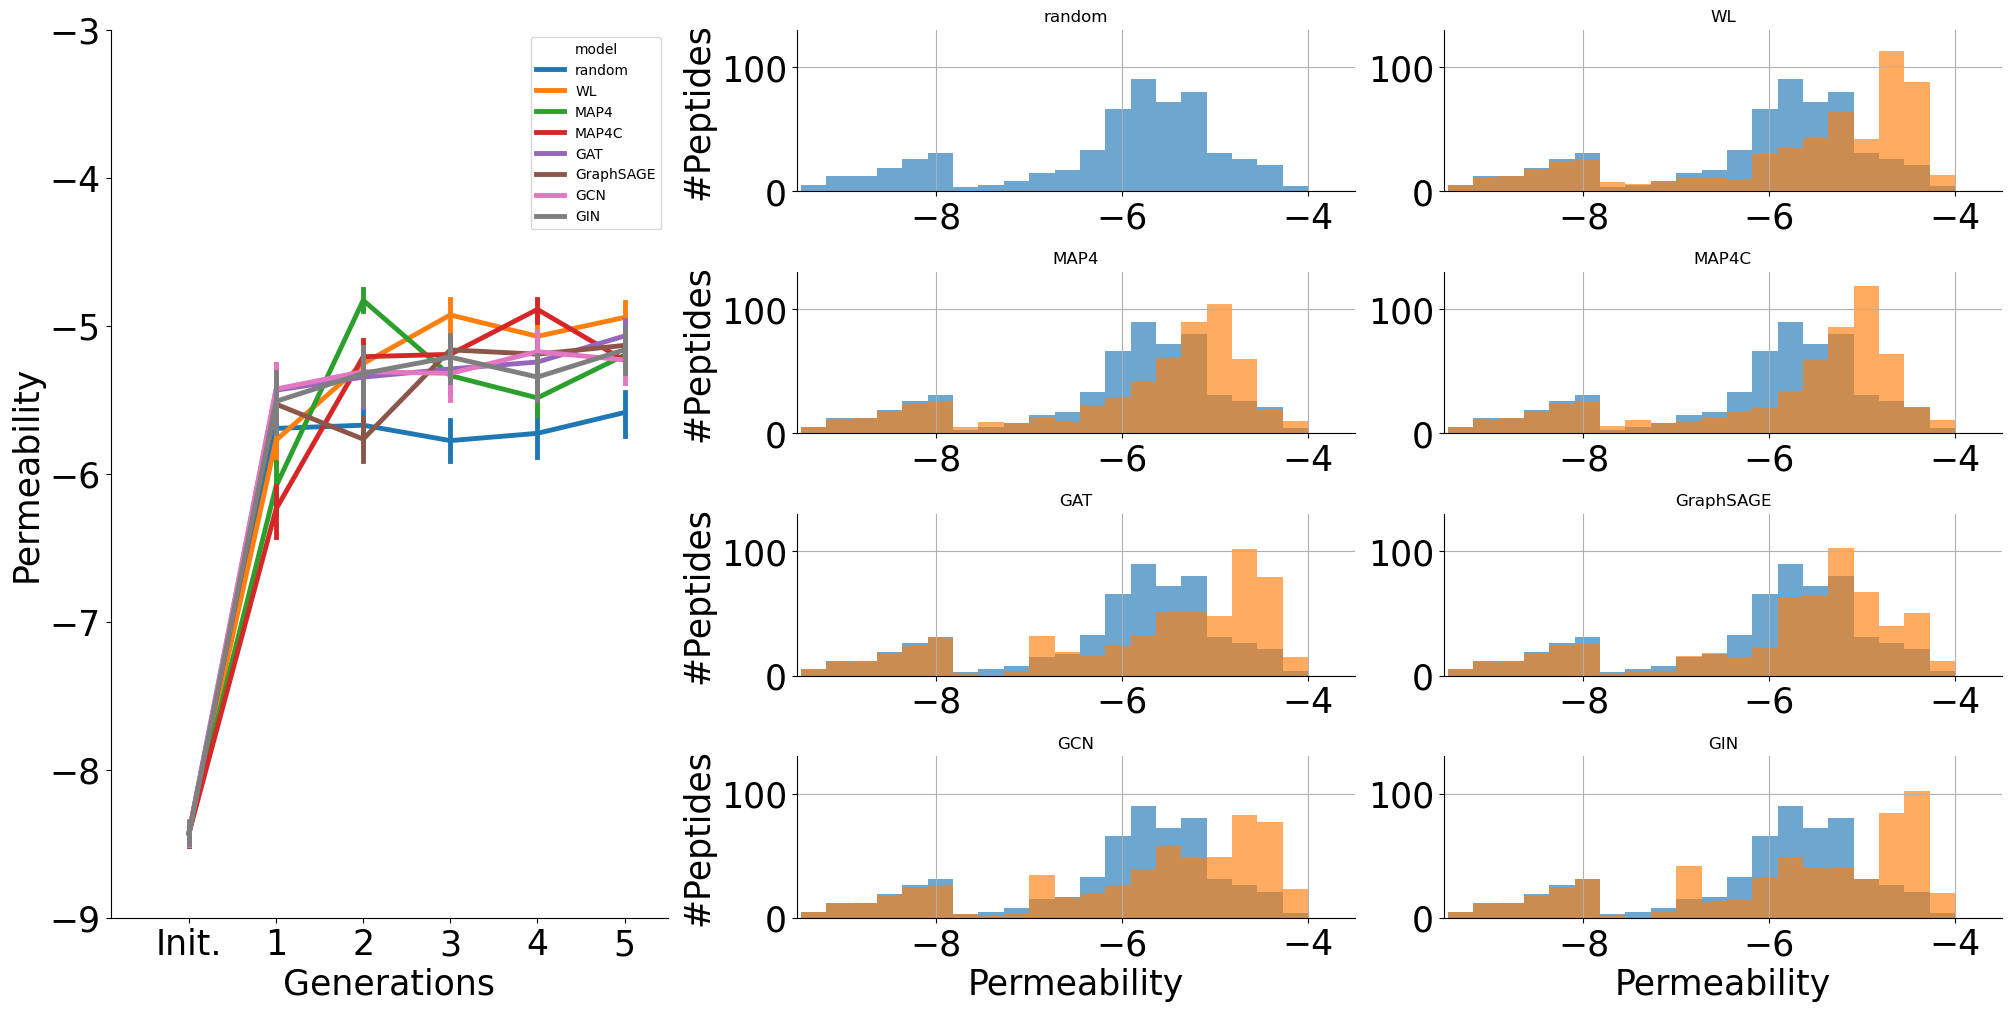

In [98]:
models = ['random', 'WL', 'MAP4', 'MAP4C', 'GAT', 'GraphSAGE', 'GCN', 'GIN']

df = pd.concat([pd.read_csv(f'results_optimization_{model}.csv') for model in models])

axarr = plt.figure(figsize=(20, 10), layout="constrained").subplot_mosaic(
    """
    ABC
    ADE
    AFG
    AHI
    """
)

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=axarr['A'], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

axarr['A'].set_xlim([-0.9, 5.5])
axarr['A'].set_ylim([-9, -3])
axarr['A'].set_ylabel('Permeability', fontsize=25)
axarr['A'].set_xlabel('Generations', fontsize=25)
axarr['A'].xaxis.set_tick_params(labelsize=25)
axarr['A'].yaxis.set_tick_params(labelsize=25)

for ax, model in zip(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], models):
    df[df['model'] == 'random']['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    if model != 'random':
        df[df['model'] == model]['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    axarr[ax].set_xlim([-9.5, -3.5])
    axarr[ax].set_ylim([0, 130])
    axarr[ax].xaxis.set_tick_params(labelsize=25)
    axarr[ax].yaxis.set_tick_params(labelsize=25)
    axarr[ax].set_title(model)

axarr['H'].set_xlabel('Permeability', fontsize=25)
axarr['I'].set_xlabel('Permeability', fontsize=25)
axarr['B'].set_ylabel('#Peptides', fontsize=25)
axarr['D'].set_ylabel('#Peptides', fontsize=25)
axarr['F'].set_ylabel('#Peptides', fontsize=25)
axarr['H'].set_ylabel('#Peptides', fontsize=25)

sns.despine()

plt.savefig('figure_results_comparison_all_models.png', dpi=300, bbox_inches='tight')

plt.show()